In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import*
import time 
from scipy.optimize import minimize_scalar

In [2]:
# parameters
kappa = 1.0
gamma = (7.5 / 160.0) * kappa
eta = 0.1 * kappa  
g = 4 * kappa
Omega_val = 2 * g 
gamma_31 = 0.95*gamma#论文中并未提及/3>衰变到/1>和/2>的比例，这里是通过多次计算后得出的与论文最符合的比例
gamma_32 = 0.05*gamma 
STK = [0 * g, 1.6* g]
coarse_range = 3.0 * g 
N_c = 6 
N_a = 3 
U0_target = 1.6*g
n0 = 4*(eta / kappa)**2 
delta_c_fine = np.linspace(-2.0, 2.0, 1000) * g 
delta_c_coarse = np.linspace(-coarse_range, coarse_range, 601) 
delta_c_list = np.unique(np.sort(np.concatenate((delta_c_coarse, delta_c_fine))))

In [3]:
a = tensor(destroy(N_c), qeye(N_a))
s00 = tensor(qeye(N_c), basis(N_a, 0) * basis(N_a, 0).dag()) 
s11 = tensor(qeye(N_c), basis(N_a, 1) * basis(N_a, 1).dag()) 
s22 = tensor(qeye(N_c), basis(N_a, 2) * basis(N_a, 2).dag()) 
s02 = tensor(qeye(N_c), basis(N_a, 0) * basis(N_a, 2).dag()) 
s20 = s02.dag()
s12 = tensor(qeye(N_c), basis(N_a, 1) * basis(N_a, 2).dag()) 
s21 = s12.dag()

In [4]:
c_ops = []
c_ops.append(np.sqrt(kappa) * a) 
c_ops.append(np.sqrt(gamma_31) * s02)
c_ops.append(np.sqrt(gamma_32) * s12) 
all_g2_0 = []
all_Ta = []
for U0 in STK:
    g2_0_list = []
    Ta_list = []      
    for Delta_c in delta_c_list:    
        #  formula (1)
        H = (g * (a.dag() * s02 + a * s20) +         
             Omega_val * (s12 + s21) +
             U0 * a.dag() * a * s00 +
             Delta_c * a.dag() * a +                 
             Delta_c * s22 +                          
             Delta_c * s11 +                          
             eta * (a.dag() + a))                    
        rho_ss = steadystate(H, c_ops)    
        n_s = expect(a.dag() * a, rho_ss)
        if n_s > 1e-12: 
            g2 = expect(a.dag() * a.dag() * a * a, rho_ss) / (n_s**2)
        else:
            g2 = 1.0        
        g2_0_list.append(g2)
        Ta_list.append(n_s / n0)
    all_g2_0.append(g2_0_list)
    all_Ta.append(Ta_list)

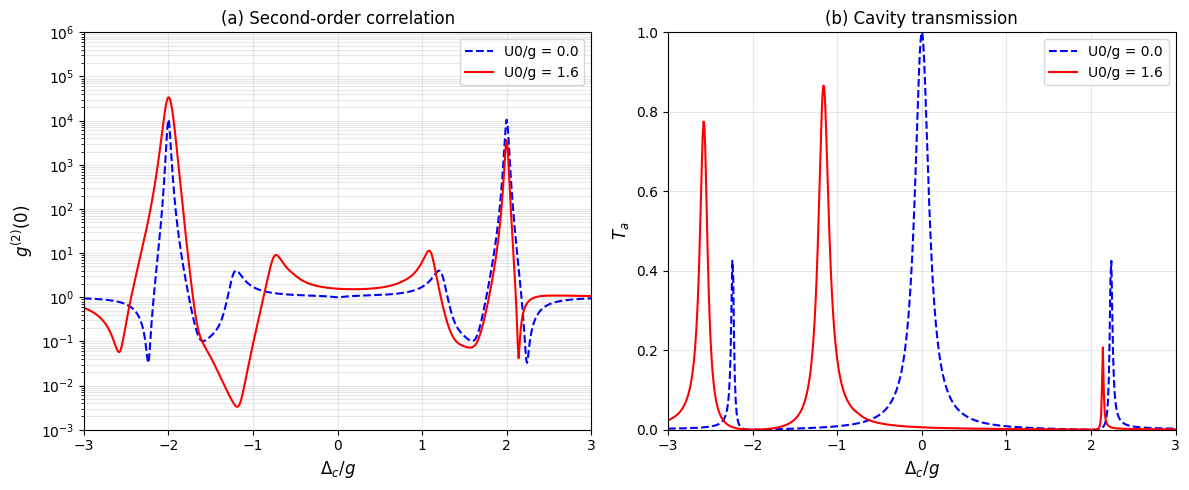

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
x_axis = delta_c_list / g
for i, U0_val in enumerate(STK):
    label = f'U0/g = {U0_val/g:.1f}'
    style = '-' if i==1 else '--' 
    color = 'red' if i==1 else 'blue'
    axes[0].semilogy(x_axis, all_g2_0[i], label=label, linestyle=style, color=color)
    axes[1].plot(x_axis, all_Ta[i], label=label, linestyle=style, color=color)
axes[0].set_xlabel(r'$\Delta_c/g$', fontsize=12)
axes[0].set_ylabel(r'$g^{(2)}(0)$', fontsize=12)
axes[0].set_xlim([-3, 3])
axes[0].set_ylim([1e-3, 1e6]) 
axes[0].legend()
axes[0].set_title('(a) Second-order correlation')
axes[0].grid(True, which="both", alpha=0.3)

axes[1].set_xlabel(r'$\Delta_c/g$', fontsize=12)
axes[1].set_ylabel(r'$T_a$', fontsize=12)
axes[1].set_xlim([-3, 3])
axes[1].set_ylim([0, 1.0])
axes[1].legend()
axes[1].set_title('(b) Cavity transmission')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
def calculate_steady_state(Delta_c_val, Omega_val, U0_val):
    H = (g * (a.dag() * s02 + a * s20) + 
         Omega_val * (s12 + s21) + 
         U0_val * a.dag() * a * s00 + 
         Delta_c_val * a.dag() * a + 
         Delta_c_val * s22 + 
         Delta_c_val * s11 + 
         eta * (a.dag() + a))
    rho_ss = steadystate(H, c_ops)
    n_s = expect(a.dag() * a, rho_ss)
    if n_s > 1e-4:
        g2 = expect(a.dag() * a.dag() * a * a, rho_ss) / (n_s**2)
    else:
        g2 = 1.0
    Ta = n_s / n0  
    return g2, Ta
def optimization_target(Delta_c_val, Omega_val, U0_val):
    g2, _ = calculate_steady_state(Delta_c_val, Omega_val, U0_val)
    if g2 < 0 or g2 > 1e6:
        return 1e6
    return g2
         
Omega_scan = np.linspace(0.0, 4.0, 60) * g  
Omega_scan[0] = 1e-3 * g 
g2_opt_list = []
Ta_opt_list = []
Omega_plot = []
start_time = time.time()
for Omega_val in Omega_scan:
    res = minimize_scalar(
        optimization_target, 
        bounds=(-3.5*g, 0.0*g), 
        args=(Omega_val, U0_target), 
        method='bounded',
        options={'xatol': 1e-5} 
    )   
    if res.success:
        best_Delta_c = res.x
        min_g2 = res.fun
        _, best_Ta = calculate_steady_state(best_Delta_c, Omega_val, U0_target)
        
        g2_opt_list.append(min_g2)
        Ta_opt_list.append(best_Ta)
        Omega_plot.append(Omega_val/g)
    else:
        print(f"Optimization failed at Omega = {Omega_val/g:.2f}")

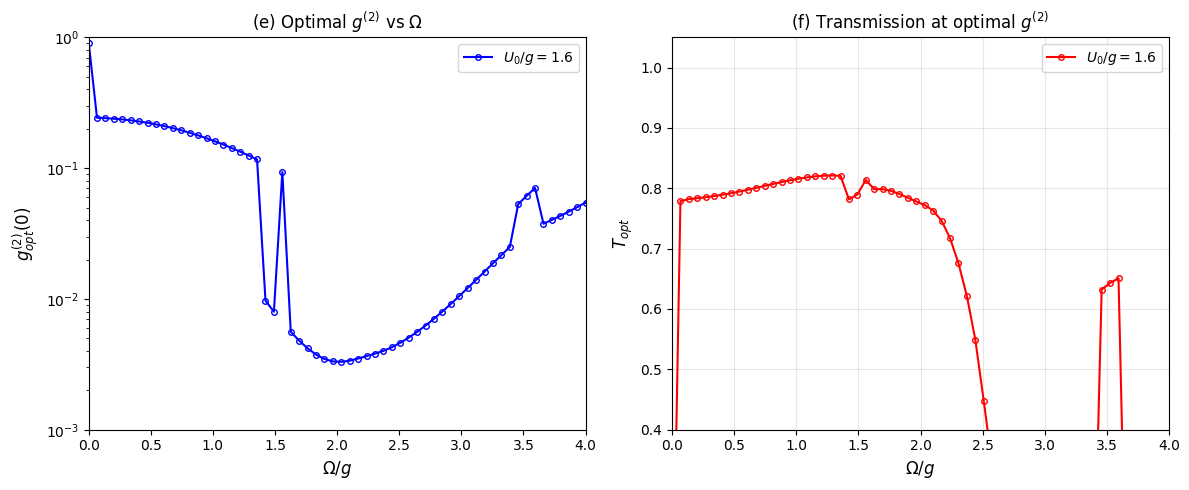

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].semilogy(Omega_plot, g2_opt_list, 'b-o', markersize=4, mfc='none', label=r'$U_0/g=1.6$')
axes[0].set_xlabel(r'$\Omega/g$', fontsize=12)
axes[0].set_ylabel(r'$g_{opt}^{(2)}(0)$', fontsize=12)
axes[0].set_title(r'(e) Optimal $g^{(2)}$ vs $\Omega$')
axes[0].set_xlim([0, 4])
axes[0].set_ylim([1e-3, 1e0]) 
axes[0].legend()
axes[1].plot(Omega_plot, Ta_opt_list, 'r-o', markersize=4, mfc='none', label=r'$U_0/g=1.6$')
axes[1].set_xlabel(r'$\Omega/g$', fontsize=12)
axes[1].set_ylabel(r'$T_{opt}$', fontsize=12)
axes[1].set_title(r'(f) Transmission at optimal $g^{(2)}$')
axes[1].set_xlim([0, 4])
axes[1].set_ylim([0.4, 1.05])
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()